### CITS5508 labsheet 5

Sample code showing how to read the CIFAR-10 data. Only cells 1 and 2 are needed. **Note: For the code to work, all the data batch files should be in the same directory with this Notebook file.**

This is only an example. Students should put in their own markdown cells. 

Rather than looking at the code in the file **<i>data_loader.py</i>**, description about the `DataLoader` class in the file can be viewed using **<i>pydoc</i>**. Try typing the following command in a terminal window (assuming that *data_loader.py* is in the current directory):<br>
<tt>
&nbsp; &nbsp; pydoc data_loader
</tt>

To convert this file into **<i>lab05-sample.py</i>**, a Python script file, for running on **Kaya** (the UWA GPU computer), do the following:
* If you are using Jupyter-lab, then select **File $>$ Export Notebook As... $>$ Executable Script $>$**. In the popped up window, select **Save File** and click the **OK** button.
* If you are using **Jupyter-notebook**, then select **File $>$ Download as $>$ Python (.py)**. Note that the option **Python (.py)** might be hidden. You would need to scroll down the list to see it. In the popped up window, select **Save File** and click the **OK** button.

**Author: Du Huynh**<br>
**Date: April 2021**

#### Step 1: Import the `DataLoader` class

In [2]:
from data_loader import DataLoader
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

#### Step 2: Call the `load_batch` function

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/cifar-10-batches-py.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

#### Step 3. A quick inspection of the outputs from the `load_batch` function

In [4]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.
# *********data SPlitting ******************
indices = list(  range(len(X_train))  )
random.shuffle(indices)

split = int( 0.8 * len(indices) )
X_val, y_val = X_train[ indices[split:] ], y_train[  indices[split:] ]
xtrain, ytrain = X_train[ indices[:split] ], y_train[ indices[:split] ]

print('X_train.shape =', xtrain.shape, 'data type:', X_train.dtype)
print('y_train.shape =', ytrain.shape, 'data type:', y_train.dtype)

print('X_val.shape =', X_val.shape, 'data type:', X_val.dtype)
print('y_val.shape =', y_val.shape, 'data type:', y_val.dtype)


X_train.shape = (40000, 32, 32, 3) data type: float32
y_train.shape = (40000,) data type: uint8
X_val.shape = (10000, 32, 32, 3) data type: float32
y_val.shape = (10000,) data type: uint8


In [5]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


<h2> Task 2: Randomly Displaying images </h2>

In [6]:
def randomly_display(dataset, labels):
  ind = list( range(len(dataset)) )
  ind = random.sample(ind, 20)

  fig=plt.figure(figsize=(10, 8))

  for i in range(1,21):
    fig.add_subplot(5, 4, i)
    plt.imshow(dataset[ind[i-1]])
    plt.title('CLass: {}'.format( class_names[ labels[ ind[i-1] ] ] ))

  plt.tight_layout()

<h3> Training Images</h3>

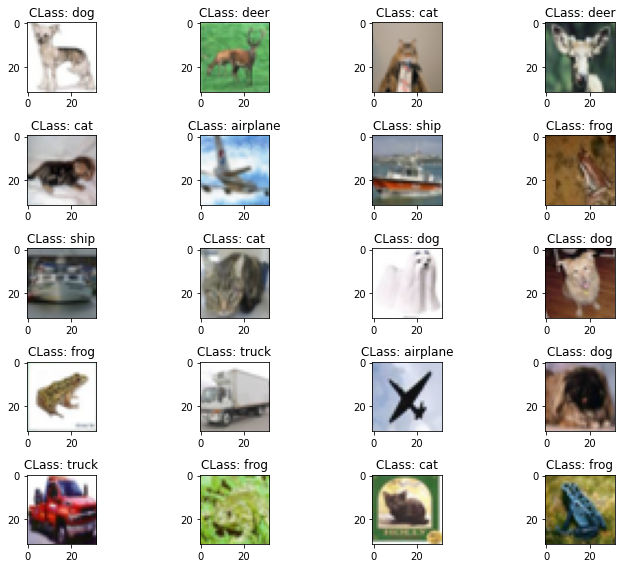

In [7]:
randomly_display(xtrain, ytrain)

<h3> Validation Images</h3>

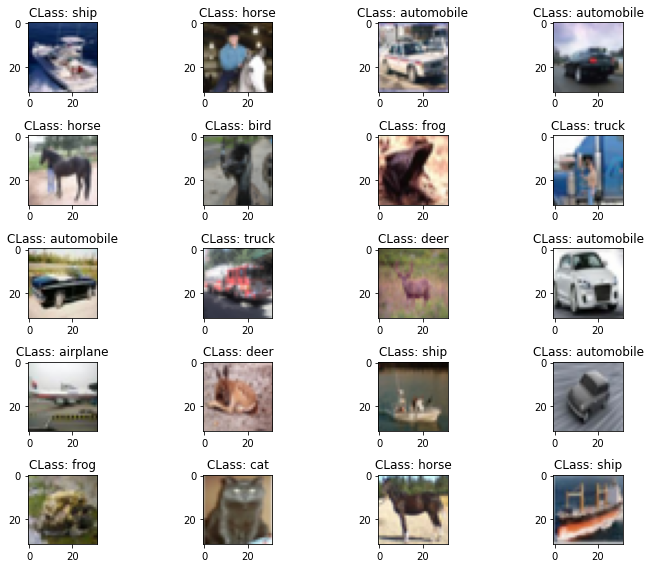

In [8]:
randomly_display(X_val, y_val)

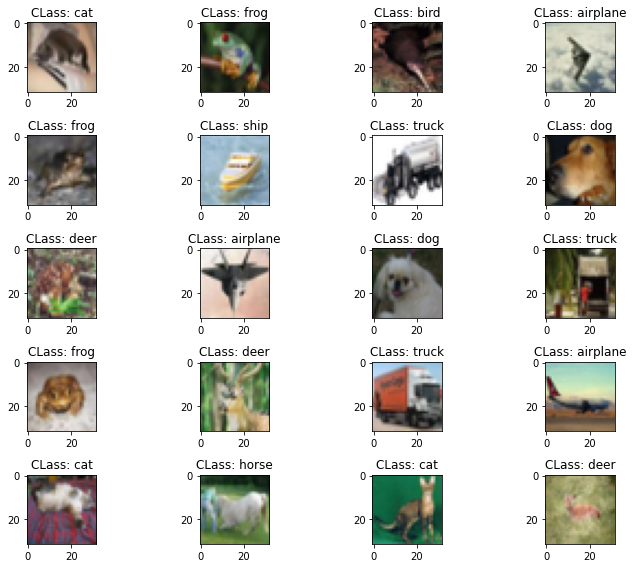

In [9]:
randomly_display(X_test, y_test)

<h2>Multi-Layer Perceptron (MLP) </h2>

In [44]:
import gc
gc.collect()

88

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

import tensorflow as tf

In [13]:
def mlp_model(drop_rate=0.6, init='random_normal'):
  model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu', kernel_initializer=init),
    Dropout(rate=drop_rate),
    Dense(256, activation='relu', kernel_initializer=init),
    # Dropout(rate=drop_rate),
    Dense(32, activation='relu', kernel_initializer=init),
    Dense(10, activation='softmax')                      
  ])
  # optim = tf.keras.optimizers.Adam( )
  model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  return model
# model = mlp_model()
# model.summary()

In [14]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import itertools

def step_lr_schedule(epoch, lr):
  if epoch %30 ==0:
    lr = lr/5
  return lr

def exp_lr_schedule(epoch):
   initial = 0.1
   lr = initial * np.exp(-0.1*epoch)
   return lr

step_lrate = tf.keras.callbacks.LearningRateScheduler(step_lr_schedule)
exp_lrate = tf.keras.callbacks.LearningRateScheduler(exp_lr_schedule)

In [15]:
drop_rate = [0.4, 0.6]
init = ['random_normal', 'glorot_normal']
callback_dict = { 'step rate': step_lrate, 'Exponential Rate ': exp_lrate}
f1scores = []
combinations = list(itertools.product(drop_rate,init,callback_dict.keys()) )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')

for comb in combinations:

  dpr, initialize, call = comb
  print('\nTraining for drop rate: {}, weight initializer: {}, callbacks: {}\n'.format(dpr, initialize, call))
  call = callback_dict[call]

  model = mlp_model(dpr, initialize )
  history = model.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val), epochs=100,\
                      batch_size=512, callbacks=[call, early_stopping] )
  
  pred = model.predict_classes(X_val)
  f1scores.append( f1_score(y_val, pred, average='weighted')  )


Training for drop rate: 0.4, weight initializer: random_normal, callbacks: step rate

Epoch 1/100
79/79 [==============================] - 2s 12ms/step - loss: 2.2146 - accuracy: 0.1720 - val_loss: 1.9476 - val_accuracy: 0.3054
Epoch 2/100
79/79 [==============================] - 1s 8ms/step - loss: 1.9446 - accuracy: 0.2966 - val_loss: 1.8366 - val_accuracy: 0.3495
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 1.8429 - accuracy: 0.3464 - val_loss: 1.7475 - val_accuracy: 0.3834
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 1.7683 - accuracy: 0.3684 - val_loss: 1.7134 - val_accuracy: 0.3887
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 1.7314 - accuracy: 0.3810 - val_loss: 1.6550 - val_accuracy: 0.4166
Epoch 6/100
79/79 [==============================] - 1s 8ms/step - loss: 1.6894 - accuracy: 0.3991 - val_loss: 1.6337 - val_accuracy: 0.4238
Epoch 7/100
79/79 [==============================] - 1s 8ms/step -

In [16]:
max_ind = np.argmax(f1scores)
sel_par = combinations[max_ind]
print('Best parameters selected for problem on hand are \ndrop rate: {}, weight initializer: {}, learning scheduler: {}\
        '.format(sel_par[0], sel_par[1], sel_par[2]) )


Best parameters selected for problem on hand are 
drop rate: 0.4, weight initializer: glorot_normal, learning scheduler: step rate        


<h4> Storing and Restoring Model for predition (Task 5)</h4>

In [56]:
import os
dir = './Surname FirstName-MLP'

# dir = os.path.join("C:\\","temp","python")
if os.path.exists(dir) and 'mlp_model.h5' in os.listdir(dir):
  model_mlp = tf.keras.models.load_model('./Surname FirstName-MLP/mlp_model.h5')
  print(model_mlp.summary())
  model_mlp.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=1,\
                      batch_size=512, callbacks=[step_lrate] )
  
else:
  if not os.path.exists(dir):
    os.mkdir(dir)
  model_mlp = mlp_model(0.4, 'glorot_normal' )
  model_mlp.summary()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')
  model_mlp.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  model_mlp.save('./Surname FirstName-MLP/mlp_model.h5')
  
# 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_79 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_80 (Dense)             (None, 10)                330       
Total params: 1,713,258
Trainable params: 1,713,258
Non-trainable params: 0
___________________________________________

In [57]:
pred = model_mlp.predict_classes( X_test )
print(classification_report(y_test, pred, target_names=class_names))

print('\n*************confusion Matrix**************')
print(confusion_matrix(y_test, pred ))


              precision    recall  f1-score   support

    airplane       0.53      0.53      0.53      1000
  automobile       0.57      0.60      0.59      1000
        bird       0.35      0.30      0.32      1000
         cat       0.35      0.27      0.30      1000
        deer       0.42      0.36      0.39      1000
         dog       0.39      0.36      0.38      1000
        frog       0.46      0.59      0.51      1000
       horse       0.53      0.55      0.54      1000
        ship       0.55      0.66      0.60      1000
       truck       0.53      0.53      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000


*************confusion Matrix**************
[[532  36  59  20  23  21  26  42 190  51]
 [ 44 605   8  22  14  24  22  24  93 144]
 [100  35 296  87 137  70 149  70  40  16]
 [ 33  28  90 269  50 205 154  61  38  72]
 [ 72  16 148  43 364  5

In [58]:
correct_ind, incorrect_ind = [], []
for i in range(len(pred)):
  if pred[i] == y_test[i]:
    correct_ind.append(i)
  else:
    incorrect_ind.append(i)

  if len(correct_ind) > 20 and len(incorrect_ind) > 20:
    break

def display_pred(dataset, ind):

  fig=plt.figure(figsize=(10, 8))

  for i in range(1,21):
    fig.add_subplot(5, 4, i)
    plt.imshow(dataset[ind[i-1]])
    # plt.title('CLass: {}'.format( class_names[ labels[ ind[i-1] ] ] ))
  plt.tight_layout()

<h4>Correctly CLassified </h4>

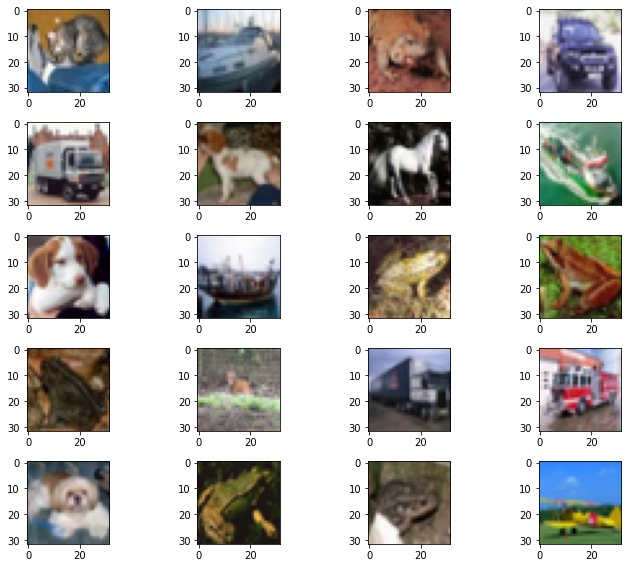

In [59]:
display_pred(X_test, correct_ind)

<h4>Incorrectly Classified </h4>

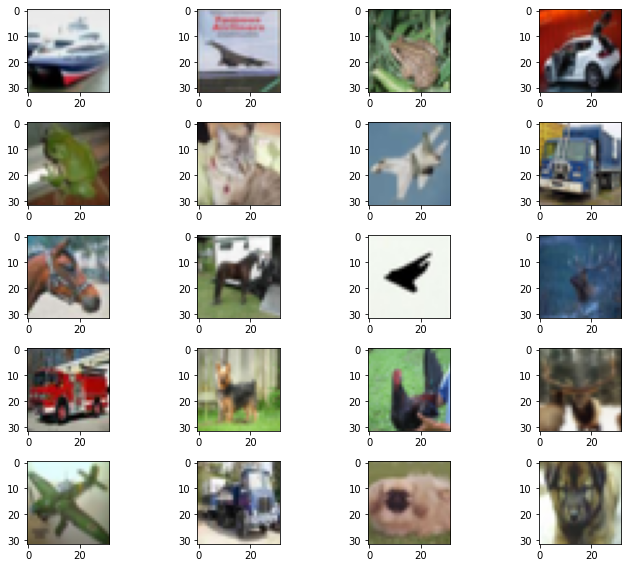

In [60]:
display_pred(X_test, incorrect_ind)

<h2><b> Convolutional Neural Network </b></h2>

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
def step_lr_schedule(epoch, lr):
  if epoch %10 ==0:
    lr = lr/5
  return lr

step_lrate = tf.keras.callbacks.LearningRateScheduler(step_lr_schedule)

In [29]:
from tensorflow.keras.regularizers import L2
def cnn_model(kernel_size=3, kn= 32, af='relu' ):
  model = Sequential([
    
    Conv2D(kn*2, (kernel_size, kernel_size),kernel_initializer='glorot_normal',activation=af, padding='same', input_shape=(32, 32, 3) ),
    MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    Dropout(0.4),
    Conv2D(kn, (kernel_size, kernel_size), kernel_initializer='glorot_normal', activation=af, padding='same', kernel_regularizer=L2(0.05)),
    MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Dropout(0.3),
    # Conv2D(kn/2, (kernel_size, kernel_size), kernel_initializer='glorot_normal', activation=af, padding='same'),
    # MaxPooling2D((2, 2)),
    # tf.keras.layers.BatchNormalization(),

    Flatten(),
    Dropout(0.4),
    Dense(256, activation=af, kernel_initializer='glorot_normal',  kernel_regularizer=L2(0.05)),
    tf.keras.layers.BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation=af, kernel_initializer='glorot_normal', kernel_regularizer=L2(0.05)),
    
    # Dropout(0.2),
    # Dense(64, activation=af, kernel_initializer='glorot_normal'),
    
    Dense(10, activation='softmax')                      
  ])
  # optim = tf.keras.optimizers.Adam( )
  model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  return model

# model = cnn_model(5, 128)
# model.summary()

In [31]:
kernel_size = [3, 5]
kernel_number = [128, 256]
activation_function = ['relu', 'tanh']
f1scores = []
combinations = list(itertools.product(kernel_size,kernel_number, activation_function) )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')

for comb in combinations:

  ks, kn, af = comb
  print('\nTraining for Kernel size: {}, Number of kernels: {}, activation function: {}\n'\
        .format(ks, kn, af))

  model = cnn_model(ks, kn, af )
  history = model.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  
  pred = model.predict_classes(X_val)
  f1scores.append( f1_score(y_val, pred, average='weighted')  )


Training for Kernel size: 3, Number of kernels: 128, activation function: relu

Epoch 1/100
79/79 [==============================] - 11s 91ms/step - loss: 38.2345 - accuracy: 0.2577 - val_loss: 23.1607 - val_accuracy: 0.1353
Epoch 2/100
79/79 [==============================] - 6s 78ms/step - loss: 18.9864 - accuracy: 0.4488 - val_loss: 14.0094 - val_accuracy: 0.1002
Epoch 3/100
79/79 [==============================] - 6s 77ms/step - loss: 10.3344 - accuracy: 0.5386 - val_loss: 10.0068 - val_accuracy: 0.1002
Epoch 4/100
79/79 [==============================] - 6s 78ms/step - loss: 6.4138 - accuracy: 0.5913 - val_loss: 7.9345 - val_accuracy: 0.1002
Epoch 5/100
79/79 [==============================] - 6s 78ms/step - loss: 4.4123 - accuracy: 0.6454 - val_loss: 7.2309 - val_accuracy: 0.1099
Epoch 6/100
79/79 [==============================] - 6s 78ms/step - loss: 3.2727 - accuracy: 0.6792 - val_loss: 6.0527 - val_accuracy: 0.1063
Epoch 7/100
79/79 [==============================] - 6s 78ms

In [34]:
max_ind = np.argmax(f1scores)
sel_par = combinations[max_ind]
print('Best parameters selected for problem on hand are \nkernel size: {}, number of kernels: {}, activation function: {}\
        '.format(sel_par[0], sel_par[1], sel_par[2]) )


Best parameters selected for problem on hand are 
kernel size: 5, number of kernels: 256, activation function: relu        


<h4> Storing and Restoring Model for predition (Task 5)</h4>

In [50]:
import os

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')
dir = './Surname FirstName-CNN'
# dir = os.path.join("C:\\","temp","python")
if os.path.exists(dir) and 'cnn_model.h5' in os.listdir(dir):
  model_cnn = tf.keras.models.load_model('./Surname FirstName-CNN/cnn_model.h5')
  print(model_cnn.summary())
  model_cnn.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=1,\
                      batch_size=512, callbacks=[step_lrate] )
  
else:
  if not os.path.exists(dir):
    os.mkdir(dir)
  model_cnn = cnn_model(kernel_size=5, kn= 256, af='relu')
  model_cnn.summary()
  model_cnn.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  model_cnn.save('./Surname FirstName-CNN/cnn_model.h5')
  
# 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 256)       3277056   
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 256)       

In [51]:
pred = model_cnn.predict_classes( X_test )
print(classification_report(y_test, pred, target_names=class_names))

print('\n*************confusion Matrix**************')
print(confusion_matrix(y_test, pred ))


              precision    recall  f1-score   support

    airplane       0.86      0.82      0.84      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.78      0.70      0.74      1000
         cat       0.69      0.64      0.66      1000
        deer       0.75      0.83      0.79      1000
         dog       0.73      0.73      0.73      1000
        frog       0.81      0.90      0.86      1000
       horse       0.88      0.84      0.86      1000
        ship       0.89      0.91      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


*************confusion Matrix**************
[[823  12  34  18  22   5   6   4  47  29]
 [  7 896   2   4   3   4   7   2  13  62]
 [ 42   1 705  33  73  49  57  23  11   6]
 [ 11   3  39 639  60 140  66  18  12  12]
 [  7   2  36  37 827  1

In [47]:
correct_ind, incorrect_ind = [], []
for i in range(len(pred)):
  if pred[i] == y_test[i]:
    correct_ind.append(i)
  else:
    incorrect_ind.append(i)

  if len(correct_ind) > 20 and len(incorrect_ind) > 20:
    break

<h4>Correctly Classified </h4>

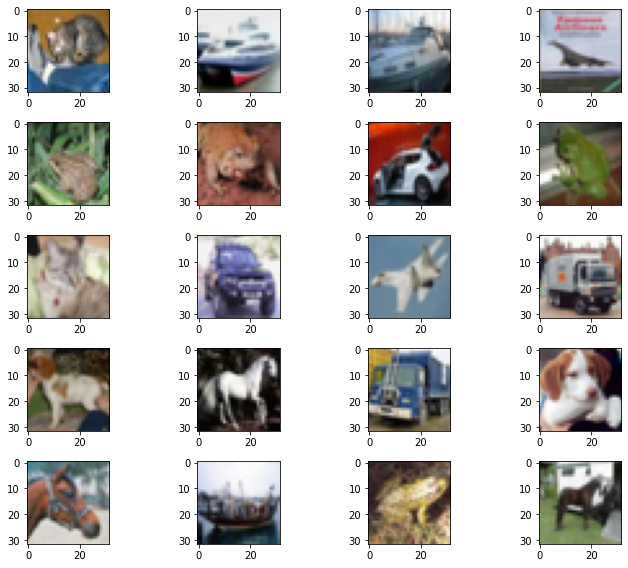

In [48]:
display_pred(X_test, correct_ind)

<h4>Incorrectly Classified </h4>

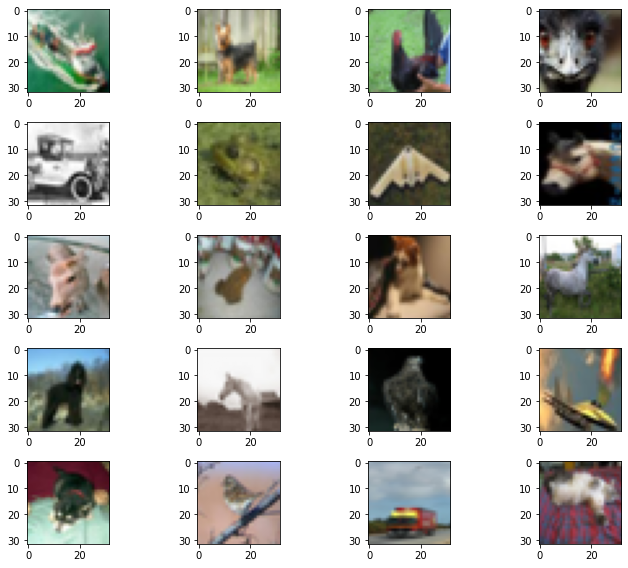

In [49]:
display_pred(X_test, incorrect_ind)